In [ ]:
!git clone https://github.com/taslimamindia/NERC.git

Cloning into 'NERC'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 143 (delta 44), reused 128 (delta 31), pack-reused 0
Receiving objects: 100% (143/143), 3.31 MiB | 5.07 MiB/s, done.
Resolving deltas: 100% (44/44), done.


# Importation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from nltk import word_tokenize, sent_tokenize, download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

import tensorflow as tf
import os

from keras.utils import to_categorical, pad_sequences

In [17]:
# download('wordnet') # for google colab
# download('stopwords')

# Class define form data.

In [2]:
class Data(object):
    unique_words = {"<PAD>":0}
    unique_ner_tags = {"O":0}
    MAX_LENGTH = 50
    VOCAB_SIZE = 100
    def __init__(self):
        self.sentences = []
        self.sentences_num = None
        self.ner_tags = []
        self.ner_tags_num = None
        self.chunk_tags = []
        self.pos_tags = []
        self.x, self.y = None, None
    def word2idx(self, word:str):
        return Data.unique_words.get(word, None)
    def idx2word(self, index:int):
        for word, value in Data.unique_words.items():
            if index is value: return word
        return None    
    def tag2idx(self, tag):
        return Data.unique_ner_tags.get(tag, None)
    def idx2tag(self, index):
        for tag, value in Data.unique_ner_tags.items():
            if index == value: return tag
        return None
    def unicity(self):
        unique_sent, unique_tag = set(), set()
        [unique_tag.update(tags) for tags in self.ner_tags_num]
        [unique_sent.update(tags) for tags in self.sentences_num]
        max_tags = len(Data.unique_ner_tags)
        max_words = len(Data.unique_words)
        for word in list(unique_sent):
            if Data.unique_words.get(word, None) == None:
                Data.unique_words[word] = max_words
                max_words += 1
        for tag in list(unique_tag):
            if Data.unique_ner_tags.get(tag, None) == None:
                Data.unique_ner_tags[tag] = max_tags
                max_tags += 1


# Loading data

In [3]:
class Loading():
    def __init__(self, path):
        if os.path.exists("../Data/conll2003_english/"): 
            base_file = "../Data/conll2003_english/"
        else:
            base_file = "/content/NERC/Data/conll2003_english/"        
        self.data = Data()
        self.load_sentences(base_file + path)
    def load_sentences(self, filepath):
        tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                    if len(tokens) > 0:
                        self.data.sentences.append(tokens)
                        self.data.pos_tags.append(pos_tags)
                        self.data.chunk_tags.append(chunk_tags)
                        self.data.ner_tags.append(ner_tags)
                        tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
                else:
                    l = line.split(' ')
                    tokens.append(l[0])
                    pos_tags.append(l[1])
                    chunk_tags.append(l[2])
                    ner_tags.append(l[3].strip('\n'))

# Preprocessing

In [4]:
class Preprocessing():
    def __init__(self, data:Data, text=None, lang="english"):
        self.data = data
        self.text = text
        self.lang = lang
        if text == None:
            self.data.sentences_num = self.data.sentences
            self.data.ner_tags_num = self.data.ner_tags
    
    def tokenize(self):
        if self.text != None:
            sentenses = [word_tokenize(sentence, language=self.lang) for sentence in sent_tokenize(self.text, language=self.lang)]
            self.data.sentences = [[token for token in sentence if token not in stopwords.words(self.lang)] for sentence in sentenses]
            self.data.sentences_num = self.data.sentences
        
    def lowercasing(self):
        self.data.sentences_num = [[word.lower() for word in sentence] for sentence in self.data.sentences_num]
    
    def lemmatize(self):
        lemmatizer = WordNetLemmatizer()
        self.data.sentences_num = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in self.data.sentences_num]
    
    def remove_stopword(self):
        punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
        punctuations = stopwords.words(self.lang) + punctuation
        sentences = [[(self.data.sentences_num[i][j], self.data.ner_tags[i][j]) for j in range(len(self.data.sentences_num[i]))] for i in range(len(self.data.sentences_num))]
        sentences = [[(token, tag) for token, tag in sentence if token not in punctuations or tag != "O"] for sentence in sentences]
        self.data.sentences_num = [[token for token, tag in sentence] for sentence in sentences]
        self.data.ner_tags_num = [[tag for token, tag in sentence] for sentence in sentences]

# Vectorization

In [5]:
class Vectorization():
    def __init__(self, data:Data):
        self.data = data
    
    def word2vec(self):
        word2vec_model = Word2Vec(self.data.sentences_num, min_count=1, vector_size=Data.VOCAB_SIZE, window=5)
        self.data.sentences_num = [[word2vec_model.wv[word] for word in sentence] for sentence in self.data.sentences_num]
    
    def padding_x(self):
        self.data.x = pad_sequences(
            sequences=self.data.sentences_num, 
            maxlen=self.data.MAX_LENGTH, 
            dtype="float32", 
            padding="post", 
            value=np.zeros((Data.VOCAB_SIZE,), dtype="float32")
        )
    
    def vectorized_x(self):
        self.word2vec()
        self.padding_x()
        
    def tag2num(self):
        NUM_CLASSES = len(Data.unique_ner_tags)
        self.data.ner_tags_num = [[to_categorical(Data.unique_ner_tags.get(tag), num_classes=NUM_CLASSES) for tag in tags] for tags in self.data.ner_tags_num]
    
    def padding_y(self):
        self.data.y = pad_sequences(
            sequences=self.data.ner_tags_num, 
            maxlen=self.data.MAX_LENGTH,
            padding="post", 
            dtype="float32",
            value=to_categorical(Data.unique_ner_tags.get("O"), num_classes=len(Data.unique_ner_tags))
        )
    
    def vectorized_y(self):
        self.tag2num()
        self.padding_y()

# Main

### Visualization

In [8]:
train = Loading("train.txt").data
test = Loading("test.txt").data
valid = Loading("valid.txt").data

In [61]:
class Visualisation:
    def __init__(self, train: Data, test: Data, valid: Data, pos: int):
        if pos == 0:
            Sentences = train.sentences + test.sentences + valid.sentences
            Tags = train.ner_tags + test.ner_tags + valid.ner_tags
        elif pos == 1:
            Sentences = train.sentences_num + test.sentences_num + valid.sentences_num
            Tags = train.ner_tags_num + test.ner_tags_num + valid.ner_tags_num
        X, y = [], []
        [
            [X.append(word) for word in sentence]
            for sentence in Sentences
        ]
        [
            [y.append(tag) for tag in tags]
            for tags in Tags
        ]
        self.df = pd.DataFrame({"word": X, "label": y})
    def classNumber(self):
        hist = self.df.groupby("label").count()
        return hist
    def classNumberHistogram(self):
        hist = self.df.groupby("label").count()
        hist = pd.DataFrame({"class":hist.index, "count": hist["word"]})
        hist = hist.to_numpy().tolist()
        cl = [t[0] for t in hist]
        nbr = [t[1] for t in hist]
        sns.barplot(data=pd.DataFrame({"class":cl, "count":nbr}), x="class", y="count")

In [62]:
visualisation = Visualisation(train, test, valid, 0)

In [63]:
visualisation.classNumber()

,word
label,
B-LOC,10645
B-MISC,5062
B-ORG,9323
B-PER,10059
I-LOC,1671
I-MISC,1717
I-ORG,5290
I-PER,6991
O,250660


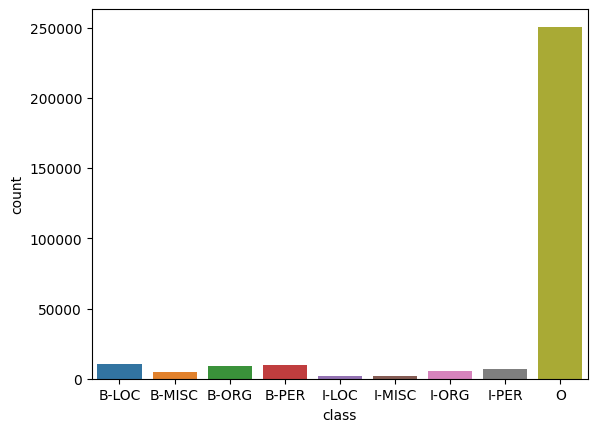

In [64]:
visualisation.classNumberHistogram()

In [18]:
visualisation.df.describe()

,word,label
count,301418,301418
unique,30289,9
top,",",O
freq,10876,250660


### New input text

In [ ]:
# test_text = Data()

# preprocessing = Preprocessing(data = test_text, text = "Obama is the president of the United States. I am from Guinea, nice to meet you.")
# preprocessing.tokenize()
# preprocessing.lowercasing()
# preprocessing.lemmatize()
# print(test_text.sentences)

# vector = Vectorization(test_text)
# vector.vectorized_x()
# print(test_text.x.shape)

### Parameters

In [6]:
# Hyperparameters
NUM_FILTERS = 256
KERNEL_SIZE = 3
DROPOUT_RATE = 0.6
BATCH_SIZE = 32
EPOCHS = 2

## Evaluation

In [7]:
def evaluation(test:Data, y_predict):
  true, false, total, predict = 0, 0, 0, 0
  x, y, z = test.y.shape
  for i in range(x):
    for j in range(y):
      real_tag = np.argmax(test.y[i][j]) 
      predict_tag = np.argmax(y_predict[i][j])
      if predict_tag == 0: predict +=1
      if real_tag != 0:
        total = total + 1
        if real_tag == predict_tag: true = true + 1
        else: false = false + 1
  print("----------------------- Evaluation -------------------------")
  print(test.y.shape)
  print(predict, x*y)
  print(true, false, total, round(true/total, 3), round(false/total, 3), end="\n\n")

def checkDataset(train, test, valid):    
    print("X_train", train.x.shape, "y_train", train.y.shape, "\n")
    print("X_test", test.x.shape, "y_test", test.y.shape, "\n")    
    print("X_valid", valid.x.shape, "y_valid", valid.y.shape)

## CNN model

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D


class Model_CNN:
    def __init__(self):
        self.train = Loading("train.txt").data
        self.test = Loading("test.txt").data
        self.valid = Loading("valid.txt").data
        # Define the model architecture
        self.model = Sequential()
        self.model.add(
            Conv1D(
                128,
                KERNEL_SIZE,
                activation="relu",
                input_shape=(Data.MAX_LENGTH, Data.VOCAB_SIZE),
                padding="same",
            )
        )
        self.model.add(Dropout(DROPOUT_RATE))
        self.model.add(Conv1D(64, KERNEL_SIZE, activation="relu", padding="same"))
        self.model.add(Dropout(DROPOUT_RATE))
        self.model.add(Conv1D(32, KERNEL_SIZE, activation="relu", padding="same"))
        self.model.add(Dropout(DROPOUT_RATE))
        self.model.add(Dense(len(Data.unique_ner_tags), activation="softmax"))

    def change(self, max_length=None, vocab_size=None):
        if max_length != None:
            Data.MAX_LENGTH = max_length
        if vocab_size != None:
            Data.VOCAB_SIZE = vocab_size

    def preprocess(self, data: Data):
        preprocessing = Preprocessing(data=data)
        preprocessing.lowercasing()
        preprocessing.lemmatize()
        preprocessing.remove_stopword()
        data.unicity()

    def preprocessing(self):
        self.preprocess(self.train)
        self.preprocess(self.test)
        self.preprocess(self.valid)

    def vectorize(self, data: Data):
        vector = Vectorization(data=data)
        vector.vectorized_x()
        vector.vectorized_y()

    def vectorization(self):
        self.vectorize(self.train)
        self.vectorize(self.test)
        self.vectorize(self.valid)

    def summary(self):
        self.model.summary()

    def trainning(self, optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        if self.valid == None:
            self.model.fit(self.train.x, self.train.y, batch_size=BATCH_SIZE, epochs=EPOCHS)
        else:
            self.model.fit(
                self.train.x,
                self.train.y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(self.valid.x, self.valid.y),
            )

    def testing(self):
        return self.model.evaluate(self.test.x, self.test.y)

    def predicting(self):
        y_predict_cnn = self.model.predict(self.test.x, batch_size=BATCH_SIZE)
        evaluation(self.test, y_predict_cnn)

In [33]:
model_cnn = Model_CNN()
model_cnn.change(max_length=50, vocab_size=200)
model_cnn.preprocessing()
model_cnn.vectorization()
model_cnn.trainning()
model_cnn.testing()
model_cnn.predicting()

Epoch 1/2
439/439 [==============================] - 16s 34ms/step - loss: 0.3374 - accuracy: 0.9460 - val_loss: 0.6809 - val_accuracy: 0.9472
Epoch 2/2
108/108 [==============================] - 1s 11ms/step
----------------------- Evaluation -------------------------
(3453, 50, 9)
172650 172650
0 8101 8101 0.0 1.0



## Model LSTM

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


class Model_LSTM:
    def __init__(self):
        self.train = Loading("train.txt").data
        self.test = Loading("test.txt").data
        self.valid = Loading("valid.txt").data
        # Define the model architecture
        self.model = Sequential()
        self.model.add(
            LSTM(
                256,
                input_shape=(Data.MAX_LENGTH, Data.VOCAB_SIZE),
                return_sequences=True,
                dropout=DROPOUT_RATE,
            )
        )
        self.model.add(LSTM(128, return_sequences=True, dropout=DROPOUT_RATE))
        self.model.add(LSTM(64, return_sequences=True, dropout=DROPOUT_RATE))
        self.model.add(LSTM(32, return_sequences=True, dropout=DROPOUT_RATE))
        self.model.add(Dense(len(Data.unique_ner_tags), activation="sigmoid"))

    def change(self, max_length=None, vocab_size=None):
        if max_length != None:
            Data.MAX_LENGTH = max_length
        if vocab_size != None:
            Data.VOCAB_SIZE = vocab_size

    def preprocess(self, data: Data):
        preprocessing = Preprocessing(data=data)
        preprocessing.lowercasing()
        preprocessing.lemmatize()
        preprocessing.remove_stopword()
        data.unicity()

    def preprocessing(self):
        self.preprocess(self.train)
        self.preprocess(self.test)
        self.preprocess(self.valid)

    def vectorize(self, data: Data):
        vector = Vectorization(data=data)
        vector.vectorized_x()
        vector.vectorized_y()

    def vectorization(self):
        self.vectorize(self.train)
        self.vectorize(self.test)
        self.vectorize(self.valid)

    def summary(self):
        self.model.summary()

    def trainning(self, optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        if self.valid == None:
            self.model.fit(
                self.train.x, self.train.y, batch_size=BATCH_SIZE, epochs=EPOCHS
            )
        else:
            self.model.fit(
                self.train.x,
                self.train.y,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(self.valid.x, self.valid.y),
            )

    def testing(self):
        return self.model.evaluate(self.test.x, self.test.y)

    def predicting(self):
        y_predict_lstm = self.model.predict(self.test.x, batch_size=BATCH_SIZE)
        evaluation(self.test, y_predict_lstm)

In [9]:
model_lstm = Model_LSTM()
model_lstm.change(max_length=50, vocab_size=200)
model_lstm.preprocessing()
model_lstm.vectorization()
model_lstm.summary()
model_lstm.trainning()
model_lstm.testing()
model_lstm.predicting()

KeyboardInterrupt: 

## Tools

In [ ]:
# !pip install tensorflow-addons

In [ ]:
# model_LSTM.save("../Data/model_lstm.keras")

In [ ]:
# model_LSTM = tf.keras.models.load_model("../Data/model_lstm.keras")

In [ ]:
# # np.quantile(sort([1, 2, 3, 8, 7]), 0.50)
# dico = {}
# for tags in test.sentences + train.sentences + valid.sentences:
#   if dico.get(len(tags), None) == None:
#     dico[len(tags)] = 1
#   dico[len(tags)] += 1
# sorted(list(dico.items()), key= lambda x: x[1])

In [ ]:
# entities = dict(zip(Data.unique_ner_tags.keys(), [0 for i in range(len(Data.unique_ner_tags))]))
# for tags in test.ner_tags:
#     for tag in tags:
#         entities[tag] += 1
# is_entities = 0
# is_not_entities = 0
# for tag, nbr in entities.items():
#     if tag != 'O': is_entities += nbr
#     else: is_not_entities += nbr
# print(entities)
# print(is_entities, is_not_entities)

## TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
class TF_IDF:
    def __init__(self):
        self.train = Loading("train.txt").data
        self.test = Loading("test.txt").data
        self.valid = Loading("valid.txt").data

    def __preprocess_tfidf(self, data: Data):
        preprocessing = Preprocessing(data=data)
        preprocessing.lowercasing()
        preprocessing.lemmatize()
        preprocessing.remove_stopword()
        data.unicity()

    def preprocessing(self):
        self.__preprocess_tfidf(self.train)
        self.__preprocess_tfidf(self.test)
        self.__preprocess_tfidf(self.valid)

    def __getMatrix(self, max_length, tfidf_matrix, data: Data, feature_names):
        entities_data = []
        for doc_index in range(len(data.sentences_num)):
            doc_tfidf_scores = tfidf_matrix[doc_index].toarray().flatten()
            top_indices = doc_tfidf_scores.argsort()[: -max_length - 1 : -1]
            doc_entities = [feature_names[i] for i in top_indices]
            entities_data.append(doc_entities)
        data.sentences_num = entities_data

    def __formalize_tfidf(self, data: Data):
        return [
            " ".join(["".join([word, "__", tag]) for word, tag in zip(words, tags)])
            for words, tags in zip(data.sentences_num, data.ner_tags_num)
        ]

    def __deformalize_tfidf(self, data: Data):
        sentences_tags = data.sentences_num
        data.ner_tags_num = [[sent_tag.split("__")[1] for sent_tag in sentences_tags] for sentences_tags in sentences_tags]
        data.sentences_num = [[sent_tag.split("__")[0] for sent_tag in sentences_tags] for sentences_tags in sentences_tags]

    def vectorization(self):
        vectorizer = TfidfVectorizer(
            lowercase=False,
            analyzer="word",
            stop_words=None,
            token_pattern="[\S]+",
            tokenizer=None,
            preprocessor=None,
        )
        # formatted
        data_train = self.__formalize_tfidf(self.train)
        data_test = self.__formalize_tfidf(self.test)
        data_valid = self.__formalize_tfidf(self.valid)
        # Tf-idf vectorization
        tfidf_matrix_train = vectorizer.fit_transform(data_train)
        tfidf_matrix_test = vectorizer.transform(data_test)
        tfidf_matrix_valid = vectorizer.transform(data_valid)
        feature_names = vectorizer.get_feature_names_out()
        # Generation of the matrix
        self.__getMatrix(Data.MAX_LENGTH, tfidf_matrix_train, self.train, feature_names)
        self.__getMatrix(Data.MAX_LENGTH, tfidf_matrix_test, self.test, feature_names)
        self.__getMatrix(Data.MAX_LENGTH, tfidf_matrix_valid, self.valid, feature_names)
        # unformatted
        self.__deformalize_tfidf(self.train)
        self.__deformalize_tfidf(self.test)
        self.__deformalize_tfidf(self.valid)

In [68]:
tfidf = TF_IDF()
tfidf.preprocessing()
# tfidf.vectorization()

In [65]:
train = Loading("train.txt").data
test = Loading("test.txt").data
valid = Loading("valid.txt").data
visualisation = Visualisation(train, test, valid, 0)
visualisation.classNumber()

,word
label,
B-LOC,10645
B-MISC,5062
B-ORG,9323
B-PER,10059
I-LOC,1671
I-MISC,1717
I-ORG,5290
I-PER,6991
O,250660


In [69]:
visualisation2 = Visualisation(tfidf.train, tfidf.test, tfidf.valid, 1)
visualisation2.classNumber()

,word
label,
B-LOC,10645
B-MISC,5062
B-ORG,9323
B-PER,10059
I-LOC,1671
I-MISC,1717
I-ORG,5290
I-PER,6991
O,136593


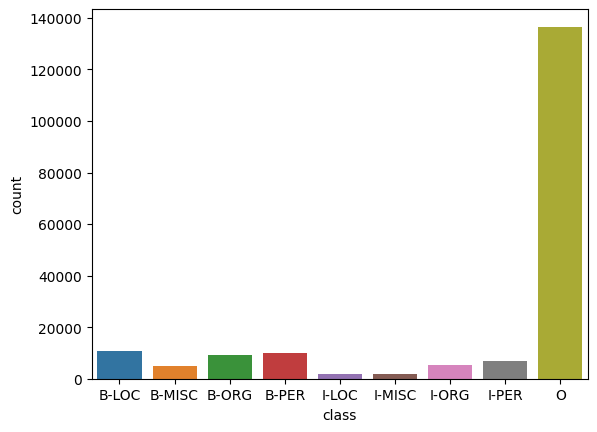

In [70]:
visualisation.classNumberHistogram()

In [1]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
C:\Users\tasli/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D

# # Load data
# df = pd.read_csv("ner_data.csv", encoding="ISO-8859-1", error_bad_lines=False)
# df = df.fillna(method="ffill")
# sentences = df.groupby("Sentence #")["Word"].apply(list).values
# tags = df.groupby("Sentence #")["Tag"].apply(list).values

# # Perform TF-IDF
# vectorizer = TfidfVectorizer(ngram_range=(1,2))
# X_tfidf = vectorizer.fit_transform([" ".join(sent) for sent in sentences])
# tfidf_vocab = vectorizer.vocabulary_
# tfidf_vocab_inv = {v:k for k,v in tfidf_vocab.items()}
# tfidf_weights = np.asarray(X_tfidf.mean(axis=0)).ravel()

# # Tokenize words
# MAX_NB_WORDS = 20000
# MAX_SEQ_LENGTH = 100
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(sentences)
# word_index = tokenizer.word_index

# # Convert words to sequences
# X = tokenizer.texts_to_sequences(sentences)
# X = pad_sequences(X, maxlen=MAX_SEQ_LENGTH)

# # Convert tags to sequences
# tags_index = {"O": 0, "B-LOC": 1, "I-LOC": 2, "B-PER": 3, "I-PER": 4, "B-ORG": 5, "I-ORG": 6}
# y = [[tags_index[tag] for tag in sent] for sent in tags]
# y = pad_sequences(y, maxlen=MAX_SEQ_LENGTH)

# # Split data into train and test sets
# VALIDATION_SPLIT = 0.2
# nb_validation_samples = int(VALIDATION_SPLIT * len(X))
# X_train = X[:-nb_validation_samples]
# y_train = y[:-nb_validation_samples]
# X_test = X[-nb_validation_samples:]
# y_test = y[-nb_validation_samples:]

# # Define CNN model
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, Data.VOCAB_SIZE, input_length=MAX_SEQ_LENGTH))
# model.add(Conv1D(128, 5, activation="relu"))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(7, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# # Train model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

# # Predict tags for new sentences
# def predict_tags(sentences):
#     X = tokenizer.texts_to_sequences(sentences)
#     X = pad_sequences(X, maxlen=MAX_SEQ_LENGTH)
#     y_pred = model.predict(X)
#     return [[tfidf_vocab_inv[np.argmax(tfidf_weights * y)] if np.max(tfidf_weights * y) > 0.2 else "O" for y in sent] for sent in y_pred]

# # Test predictions
# sentences_test = ["John lives in New York City.", "Steve Jobs was the founder of Apple."]
# tags_pred = predict_tags(sentences_test)
# print(tags_pred)